In [1]:
library(IBMPopSim)
library(ggplot2)
library(dplyr)


Attaching package: ‘IBMPopSim’


The following object is masked from ‘package:stats’:

    stepfun



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
#update.packages(checkBuilt=TRUE, ask=FALSE)
#install.packages("Rcpp")
#install.packages("IBMPopSim")
#install.packages("devtools")
#install.packages("IRkernel")
#IRkernel::installspec()

In [3]:
N_init=1
pop_init <- data.frame("birth"=rep(0,N_init), "death"=rep(NA,N_init), "smurfness"=rep(0,N_init), "death_cause"=rep(FALSE,N_init))
params <- list("a" = 0.039,
               "t0" = 15,
               "k_int" = 0.1911,
               "compet" = 1e-4, 
               "birth_rate" = 0.3,
               "compet2" =0,
               "n_immig"= 9)

In [4]:
immig_event <- mk_event_poisson(name="immig1", type = "entry", 
    intensity = 'n_immig', 
    kernel_code = 'newI.set_age(CUnif(0,20),t);
                   newI.smurfness=0;')

In [5]:
death_event <- mk_event_individual(name = "death1", type = "death",
    intensity_code = 'if (I.smurfness==0)
            result = 0;
        else
             result = k_int;',
    kernel_code =" I.death_cause = TRUE;"
)

In [6]:
#death_event2 <- mk_event_interaction(name = "death2", type = "death", 
#    interaction_code = 'result = compet;'
#)                                     

In [7]:
# implementing catastrophe
#death_event2 <- mk_event_interaction(name = "death2", type = "death", 
#    interaction_code = 'if (t < 130)
#                            result = compet;
#                        else
#                            result = compet * 10;'
#)  

In [8]:
# implementing seasonal variations
death_event2 <- mk_event_interaction(name = "death2", type = "death", 
    interaction_code = 'result = compet * cos(t/60)+2*compet;'
)  

In [9]:
birth_event <- mk_event_individual(type="birth",
    intensity_code = 'if (I.smurfness==0)
            result = birth_rate;
        else
            result = birth_rate/15;',
    kernel_code = 'newI.smurfness=0;
                   newI.entry=0;'
)

In [10]:
swap_event <- mk_event_individual(
    type = "swap",
    intensity_code = 'if (I.smurfness==0){
                            if (age(I,t)==0)
                                result = 0;
                            else
                                result = (a*age(I,t)*exp(-t0/age(I,t)));
                            }
                        else
                            result = 0;',
    kernel_code = 'I.smurfness=1;'
)

### Smurfness due to environmental pressure

In [11]:
swap_event2 <- mk_event_interaction(
    type = "swap",
    name = "swap2",
    interaction_code = 'if (I.smurfness==0){
                            if (age(I,t)==0)
                                result = 0;
                            else
                                result = compet2*(a*age(I,t)*exp(-t0/age(I,t)));
                            }
                        else
                            result = 0;',
    kernel_code = 'I.smurfness=1;'
)

In [12]:
model <- mk_model(
    characteristics = get_characteristics(pop_init),
    events = list(death_event, death_event2, swap_event, birth_event, immig_event, swap_event2),
    parameters = params,
    with_id = TRUE) #adds individuals IDs

summary(model)

[1] "add 'id' as individual attributes"
[1] "entry event: add 'entry' as individual attributes"
Events:
#1: individual event of type death
#2: interaction event of type death
#3: individual event of type swap
#4: individual event of type birth
#5: poisson event of type entry
#6: interaction event of type swap
--------------------------------------- 
Individual description:
names:  birth death smurfness death_cause id entry 
R types:  double double double logical integer double 
C types:  double double double bool int double
--------------------------------------- 
R parameters available in C++ code:
names:  a t0 k_int compet birth_rate compet2 n_immig 
R types:  double double double double double double double 
C types:  double double double double double double double

In [13]:
death_max <- params$k_int
swap_max <- params$a*50*exp(-params$t0/50)

In [14]:
t_final = 1000
T = 0:t_final # Simulation end time 


sim_out <- popsim(model = model, age_max = 50,
  population = pop_init,
  events_bounds = c('death1'=death_max,'death2'=params$compet*10, 'swap'= swap_max, 'birth'= params$birth_rate, 'immig1'=params$n_immig, 'swap2'=params$compet2),
  parameters = params,
  time = T)

[1] "Add 'id' attributes to the population."


Warning message in popsim(model = model, age_max = 50, population = pop_init, events_bounds = c(death1 = death_max, :
“Add 'entry' attributes to the population.”


[1] "event swap2 is deactivated"
Simulation on  [0, 1]  [1, 2]  [2, 3]  [3, 4]  [4, 5]  [5, 6]  [6, 7]  [7, 8]  [8, 9]  [9, 10]  [10, 11]  [11, 12]  [12, 13]  [13, 14]  [14, 15]  [15, 16]  [16, 17]  [17, 18]  [18, 19]  [19, 20]  [20, 21]  [21, 22]  [22, 23]  [23, 24]  [24, 25]  [25, 26]  [26, 27]  [27, 28]  [28, 29]  [29, 30]  [30, 31]  [31, 32]  [32, 33]  [33, 34]  [34, 35]  [35, 36]  [36, 37]  [37, 38]  [38, 39]  [39, 40]  [40, 41]  [41, 42]  [42, 43]  [43, 44]  [44, 45]  [45, 46]  [46, 47]  [47, 48]  [48, 49]  [49, 50]  [50, 51]  [51, 52]  [52, 53]  [53, 54]  [54, 55]  [55, 56]  [56, 57]  [57, 58]  [58, 59]  [59, 60]  [60, 61]  [61, 62]  [62, 63]  [63, 64]  [64, 65]  [65, 66]  [66, 67]  [67, 68]  [68, 69]  [69, 70]  [70, 71]  [71, 72]  [72, 73]  [73, 74]  [74, 75]  [75, 76]  [76, 77]  [77, 78]  [78, 79]  [79, 80]  [80, 81]  [81, 82]  [82, 83]  [83, 84]  [84, 85]  [85, 86]  [86, 87]  [87, 88]  [88, 89]  [89, 90]  [90, 91]  [91, 92]  [92, 93]  [93, 94]  [94, 95]  [95, 96]  [96, 97]  [

In [15]:
#mortality per age general pop
pop_final <- sim_out$population[[t_final]]
#Dx <- death_table(pop_final, 0:100, 0:100)
#Ex <- exposure_table(pop_final, 0:100, 0:100)
all_dead <- pop_final[is.na(pop_final$death)==FALSE,]
dim(all_dead[all_dead$smurfness==1&all_dead$death_cause,])[1]/dim(all_dead)[1]

[1] 0.3387634

In [16]:
dim(pop_final)[1]
head(pop_final)
dim(all_dead)[1]

[1] 167116

,id,birth,death,smurfness,death_cause,entry
,<int>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>
1,161602,976.4689,NaN,1,FALSE,0
2,162476,979.7753,NaN,1,FALSE,0
3,162863,981.2279,NaN,1,FALSE,0
4,163240,982.6883,NaN,1,FALSE,0
5,163518,983.7795,NaN,1,FALSE,0
6,163618,984.1553,NaN,1,FALSE,0


[1] 166113

In [17]:
taux_smurf_alive<- function(i){pop= sim_out$population[[i]];
                                alive <- pop[is.na(pop$death),]
return(dim(alive[alive$smurfness==1,])[1]/dim(alive)[1]) }
nalive <- function(i){pop= sim_out$population[[i]];
                                alive <- pop[is.na(pop$death),]
return(dim(alive)[1]) }

In [18]:
vec_taux_smurf_alive<- sapply(1:t_final,function(i)(taux_smurf_alive(i)))
N_alive<- sapply(1:t_final,function(i)(nalive(i)))

## age pyramid @ end of simulation

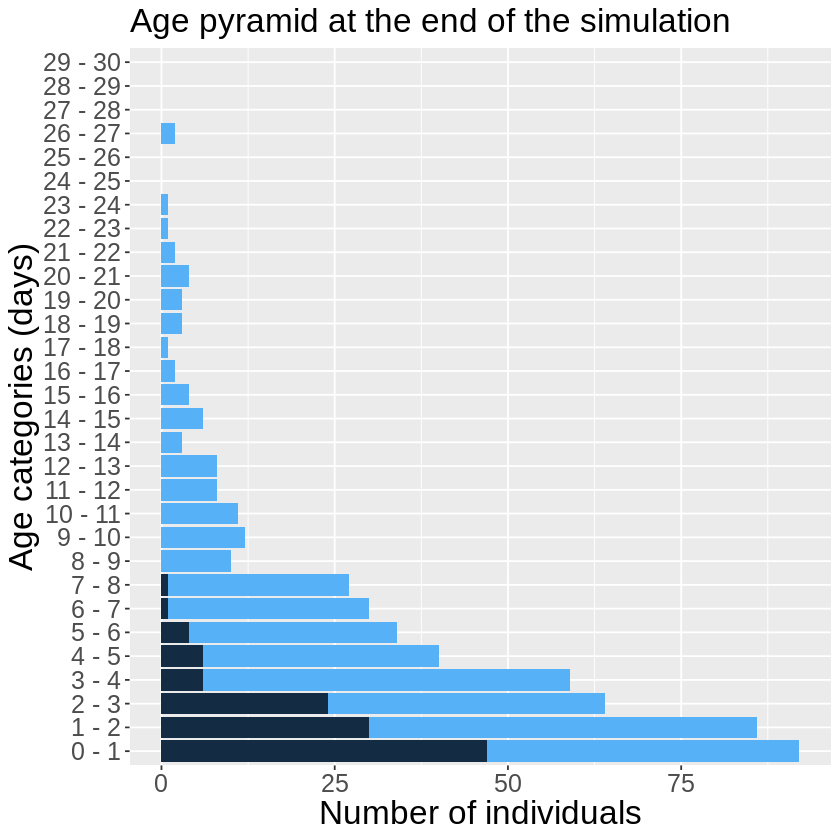

In [19]:
#pyr_init = age_pyramid(sim_out$population[[100]], time = 100,ages = 0:50)
pyr = age_pyramid(sim_out$population[[t_final]], time = 375, ages=0:30)
#head(pyr)
ggplot(pyr, aes(fill=smurfness, x=value, y=age))+
    geom_bar(position="stack", stat="identity")+
    labs(title ="Age pyramid at the end of the simulation", y="Age categories (days)", x="Number of individuals")+
    theme(axis.text.y = element_text(size = 15),
          axis.text.x = element_text(size = 15),
          axis.title = element_text(size = 20),
          plot.title = element_text(size = 20),
          legend.position = "none")

In [20]:
vec <- pyr %>% group_by(age) %>% summarise(across(everything(), sum)) %>% select(value)
pyr_s <- cbind(pyr[pyr$smurfness==1,], vec)
colnames(pyr_s) <- c("age", "smurfness", "value", "total")

Warning message:
“Removed 9 rows containing missing values (position_stack).”


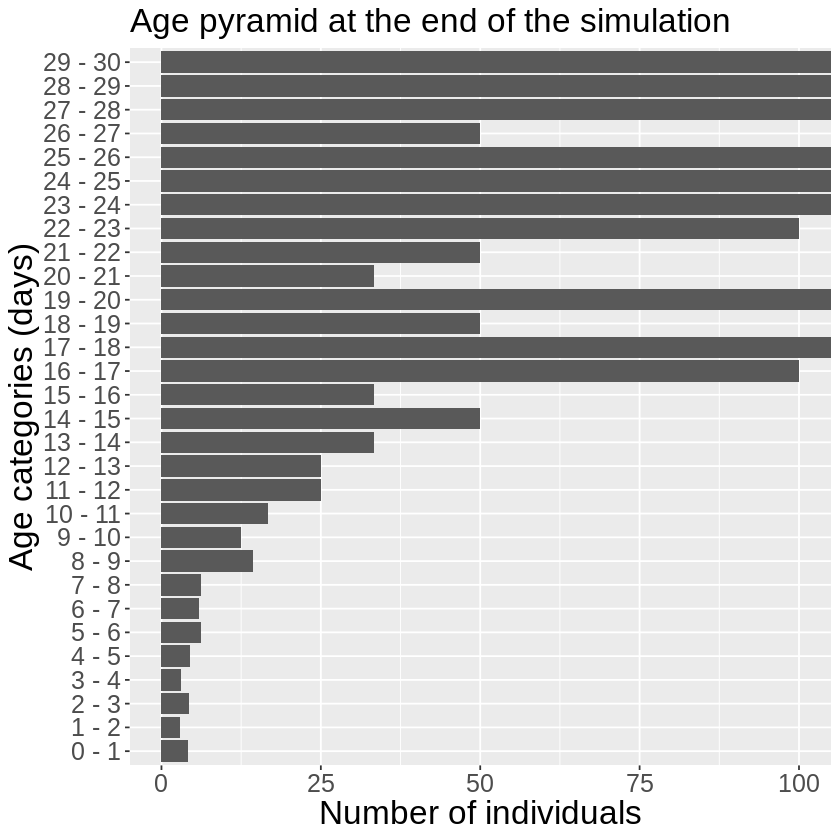

In [21]:
ggplot(pyr_s, aes(x=value/total*100, y=age))+
    geom_bar(stat="identity")+
    labs(title ="Age pyramid at the end of the simulation", y="Age categories (days)", x="Number of individuals")+
    theme(axis.text.y = element_text(size = 15),
          axis.text.x = element_text(size = 15),
          axis.title = element_text(size = 20),
          plot.title = element_text(size = 20),
          legend.position = "none")

## total population size

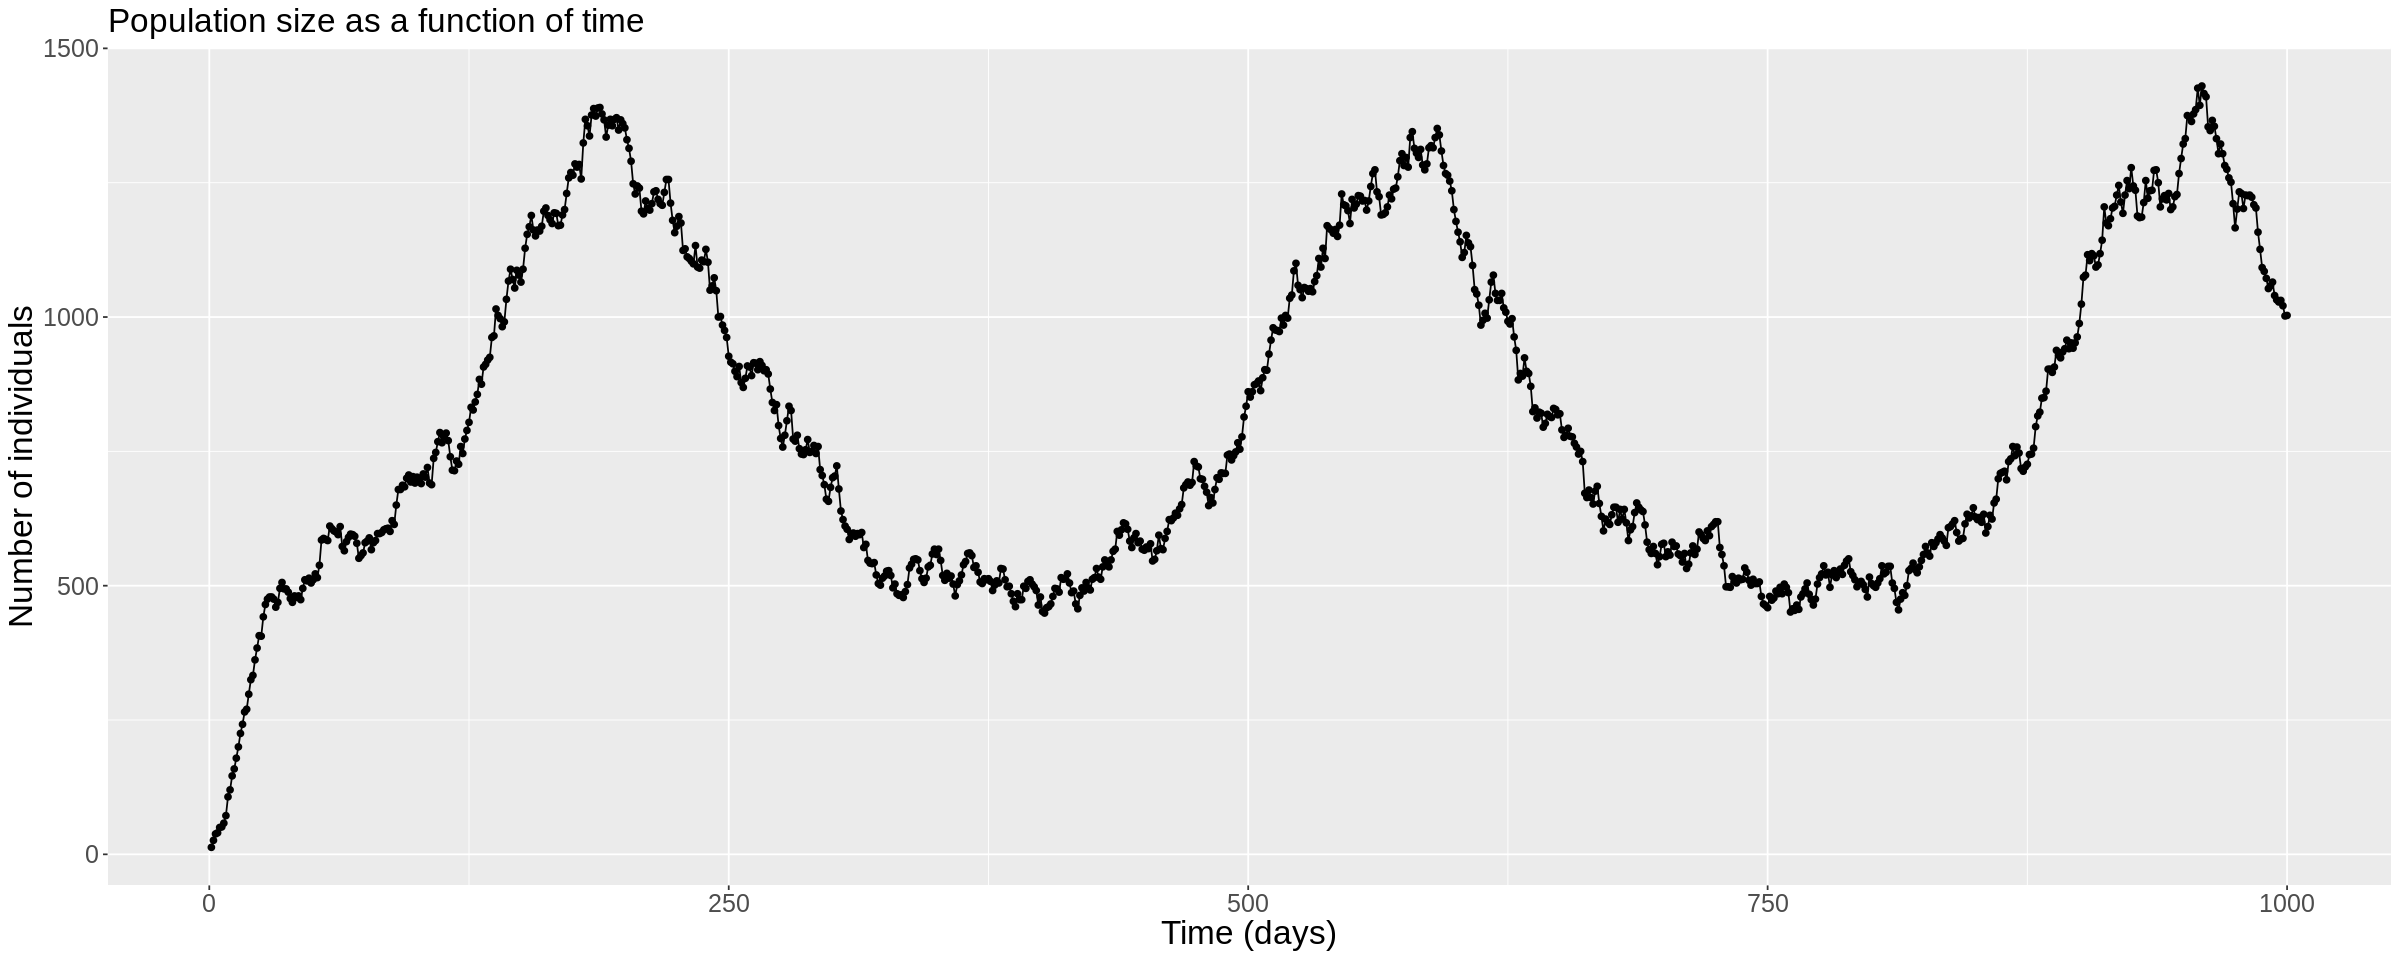

In [22]:
pop_size <- as.data.frame(cbind(1:t_final, N_alive))
colnames(pop_size)<-c("age","size")

options(repr.plot.width = 20, repr.plot.height = 8)

ggplot(pop_size, aes(x=age, y=size))+
    geom_point()+
    geom_line()+
    labs(title ="Population size as a function of time", y="Number of individuals", x="Time (days)")+
    theme(axis.text.y = element_text(size = 15),
          axis.text.x = element_text(size = 15),
          axis.title = element_text(size = 20),
          plot.title = element_text(size = 20))

## proportion of Smurfs in living pop @ t

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



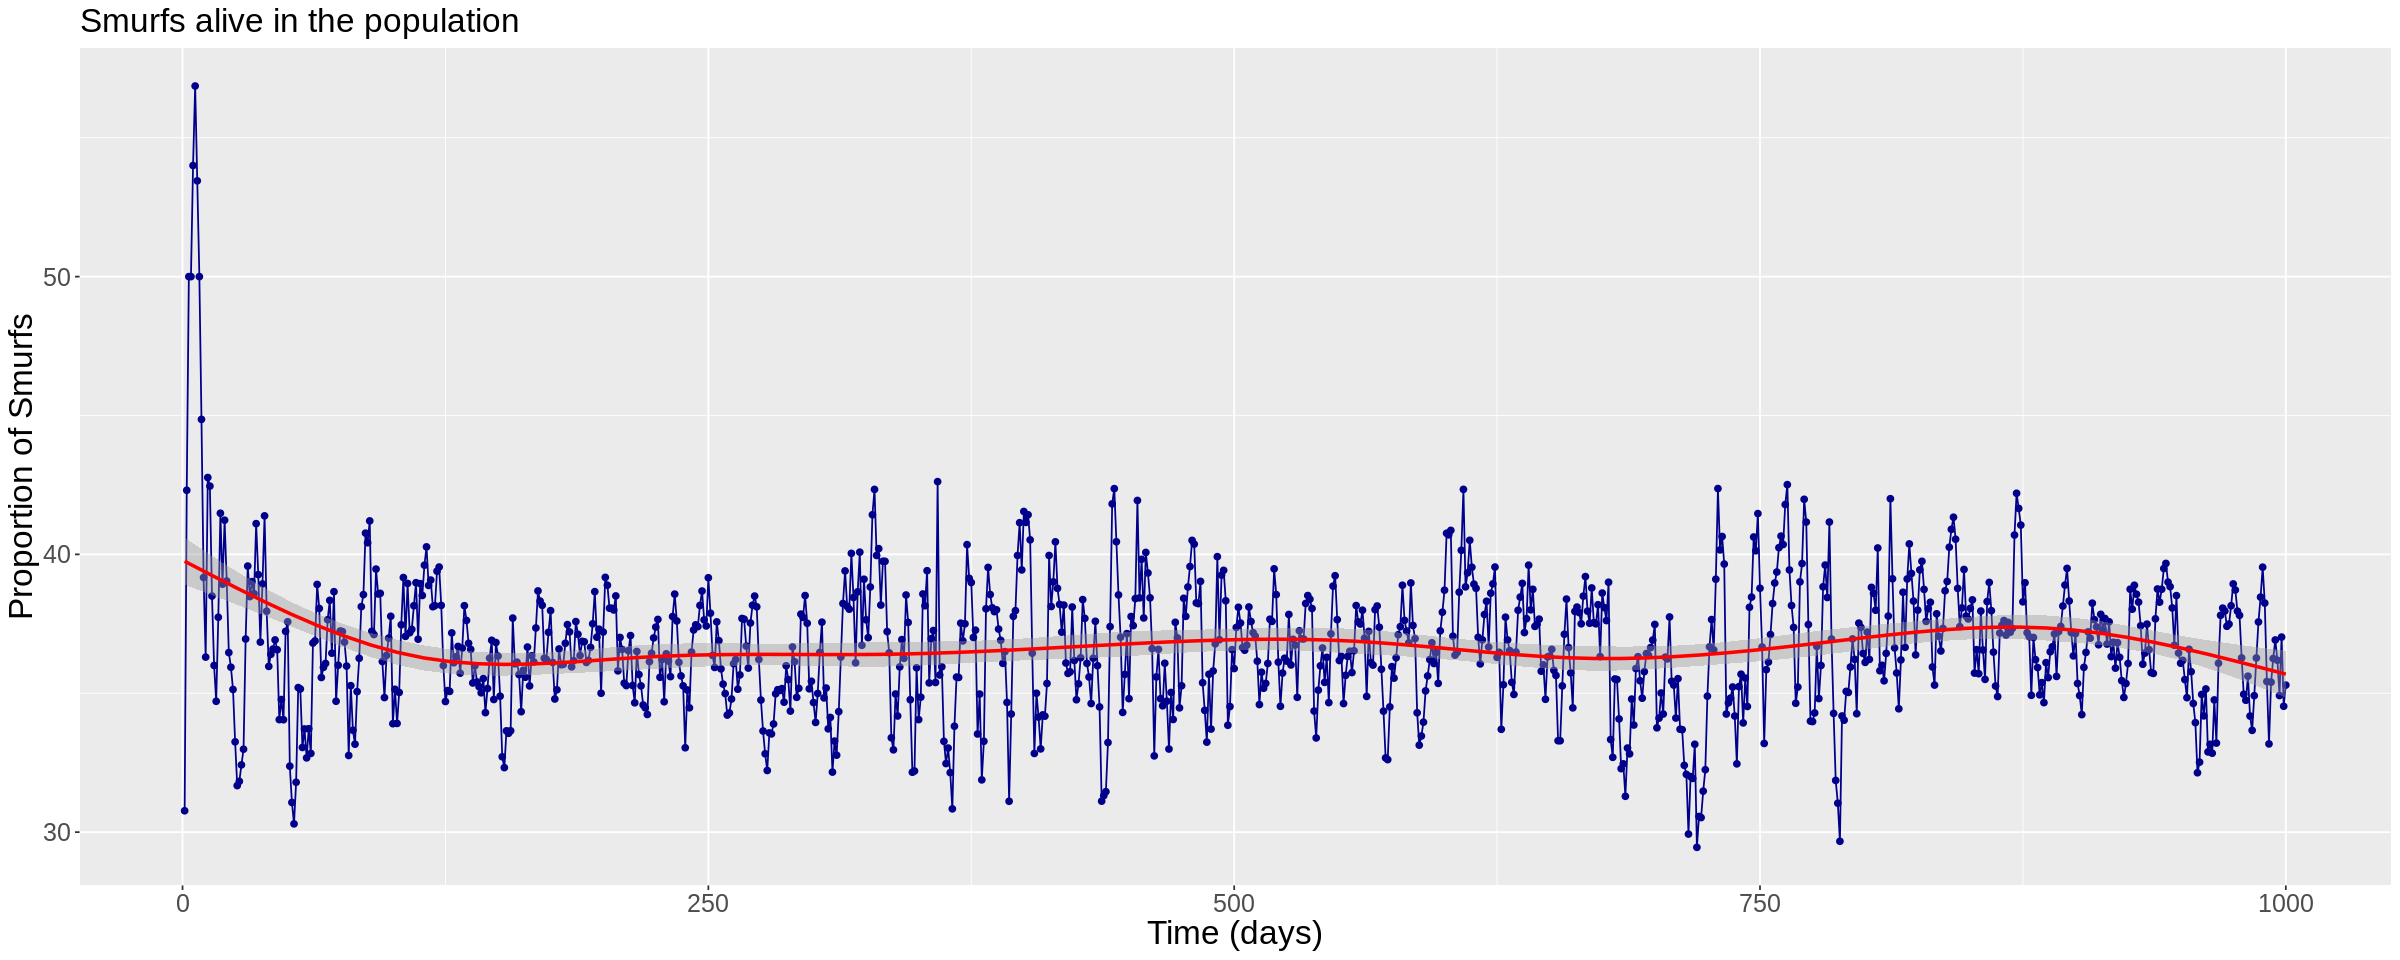

In [23]:
living_smurfs_prop <- as.data.frame(cbind(1:t_final,vec_taux_smurf_alive*100))
colnames(living_smurfs_prop) <- c("time", "prop_smurfs_alive")

options(repr.plot.width = 20, repr.plot.height = 8)

ggplot(living_smurfs_prop,aes(x=time, y=prop_smurfs_alive))+
    geom_point(colour="dark blue")+
    geom_line(colour="dark blue")+
    labs(title ="Smurfs alive in the population", y="Proportion of Smurfs", x="Time (days)")+
    theme(axis.text.y = element_text(size = 15),
          axis.text.x = element_text(size = 15),
          axis.title = element_text(size = 20),
          plot.title = element_text(size = 20)) + geom_smooth(span = 90, color = "red")

### summary graph

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



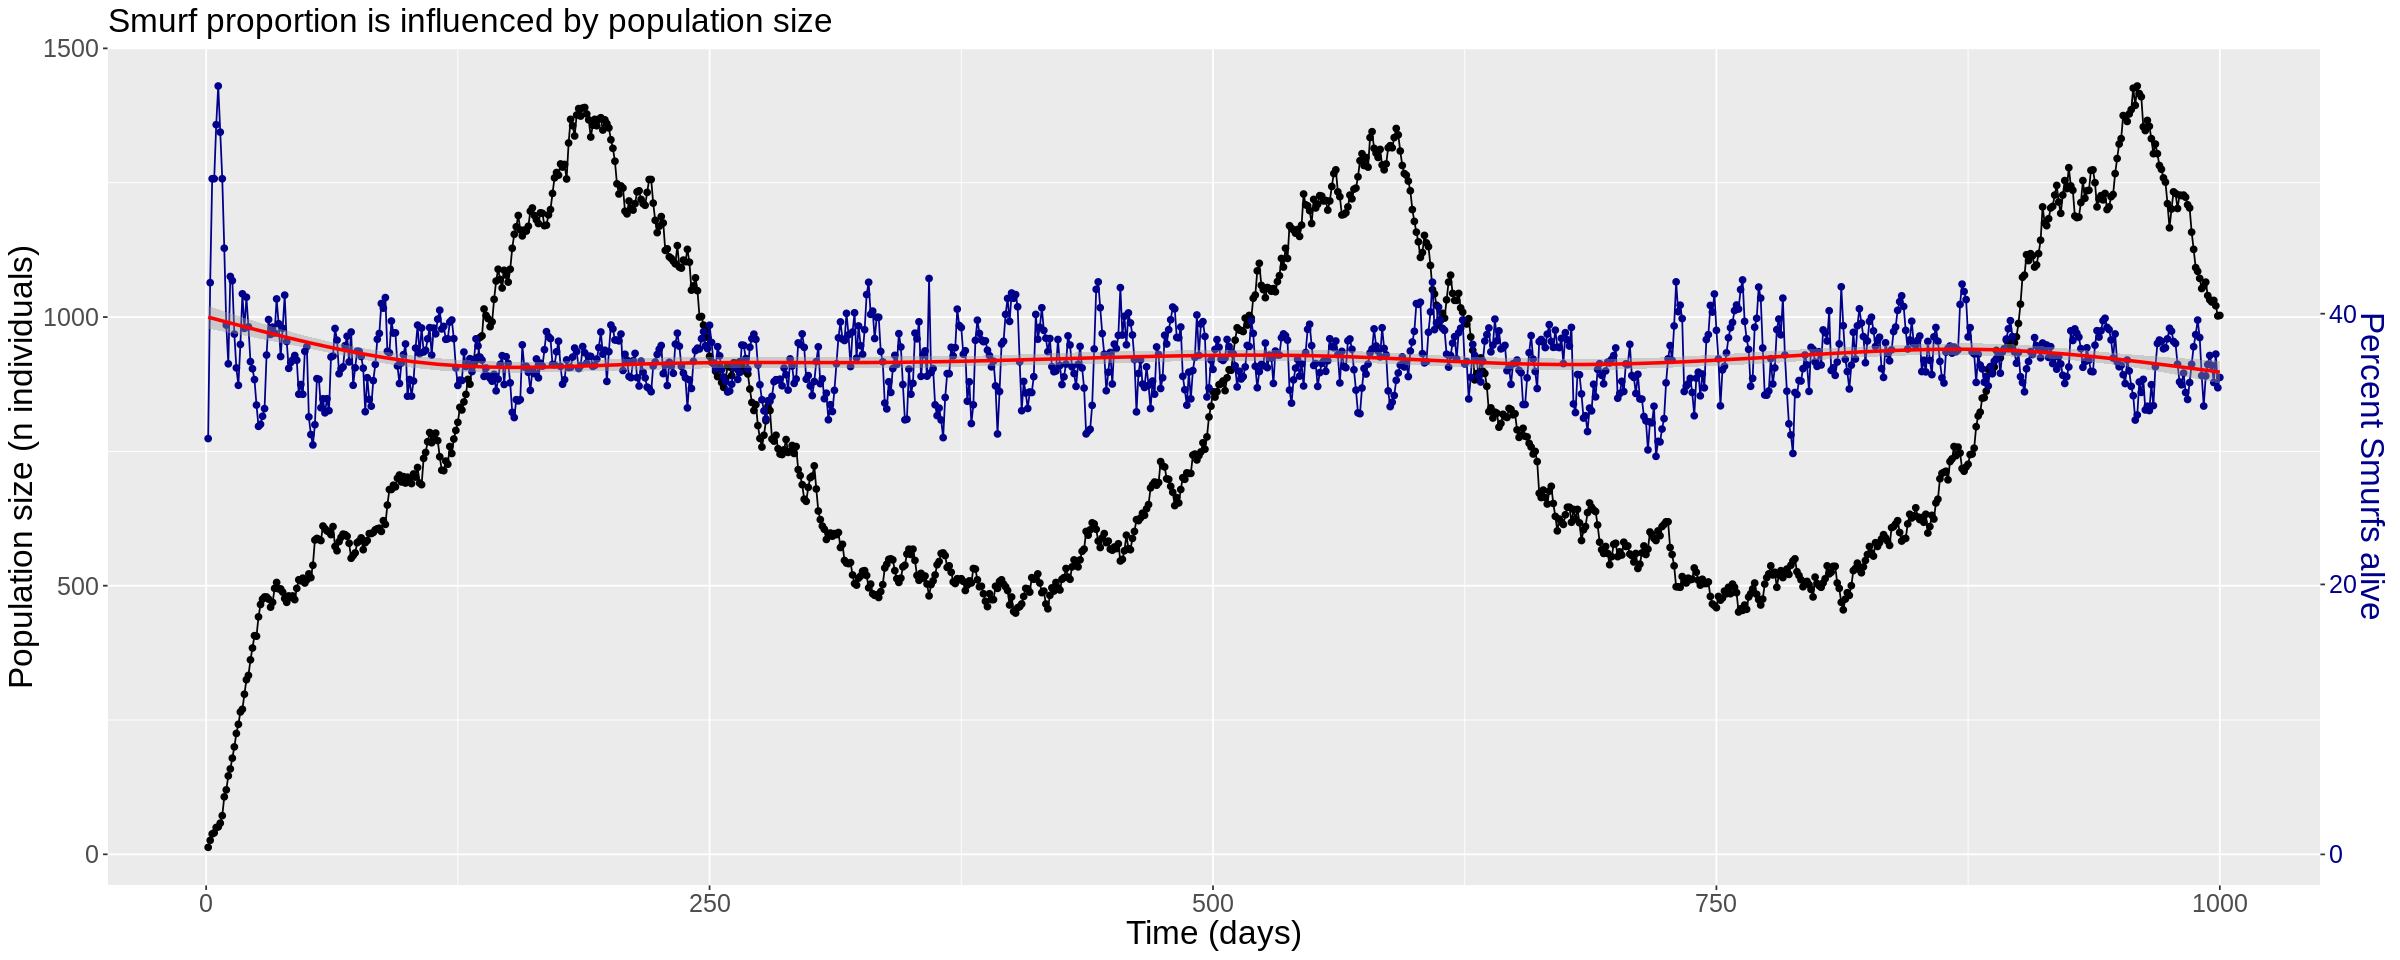

In [24]:
all_info <- cbind(pop_size,living_smurfs_prop$prop_smurfs_alive)
colnames(all_info) <- c("age", "size", "prop_smurfs_alive")
coeff = max(all_info[,2])/max(all_info[,3])
options(repr.plot.width = 20, repr.plot.height = 8)

ggplot(all_info, aes(x=age))+
    geom_point(aes(y=size))+
    geom_line(aes(y=size))+

    
    geom_point(aes(y=prop_smurfs_alive*coeff), colour = "dark blue")+
    geom_line(aes(y=prop_smurfs_alive*coeff), colour = "dark blue")+
    geom_smooth(aes(y=prop_smurfs_alive*coeff),span = 0.1, color = "red")+
    scale_y_continuous(
    
    # Features of the first axis
        name = "Population size (n individuals)",
    
    # Add a second axis and specify its features
    sec.axis = sec_axis(~./coeff, name="Percent Smurfs alive")
    )+
    labs(title ="Smurf proportion is influenced by population size",  x="Time (days)")+
    theme(axis.text.y = element_text(size = 15),
          axis.text.x = element_text(size = 15),
          axis.title = element_text(size = 20),
          plot.title = element_text(size = 20), 
          axis.text.y.right = element_text(color="dark blue"), 
          axis.title.y.right =  element_text(color="dark blue"))

## Analyse d'une cohorte

Warning message:
“Removed 875 row(s) containing missing values (geom_path).”
Warning message:
“Removed 875 row(s) containing missing values (geom_path).”
Warning message:
“Removed 875 row(s) containing missing values (geom_path).”


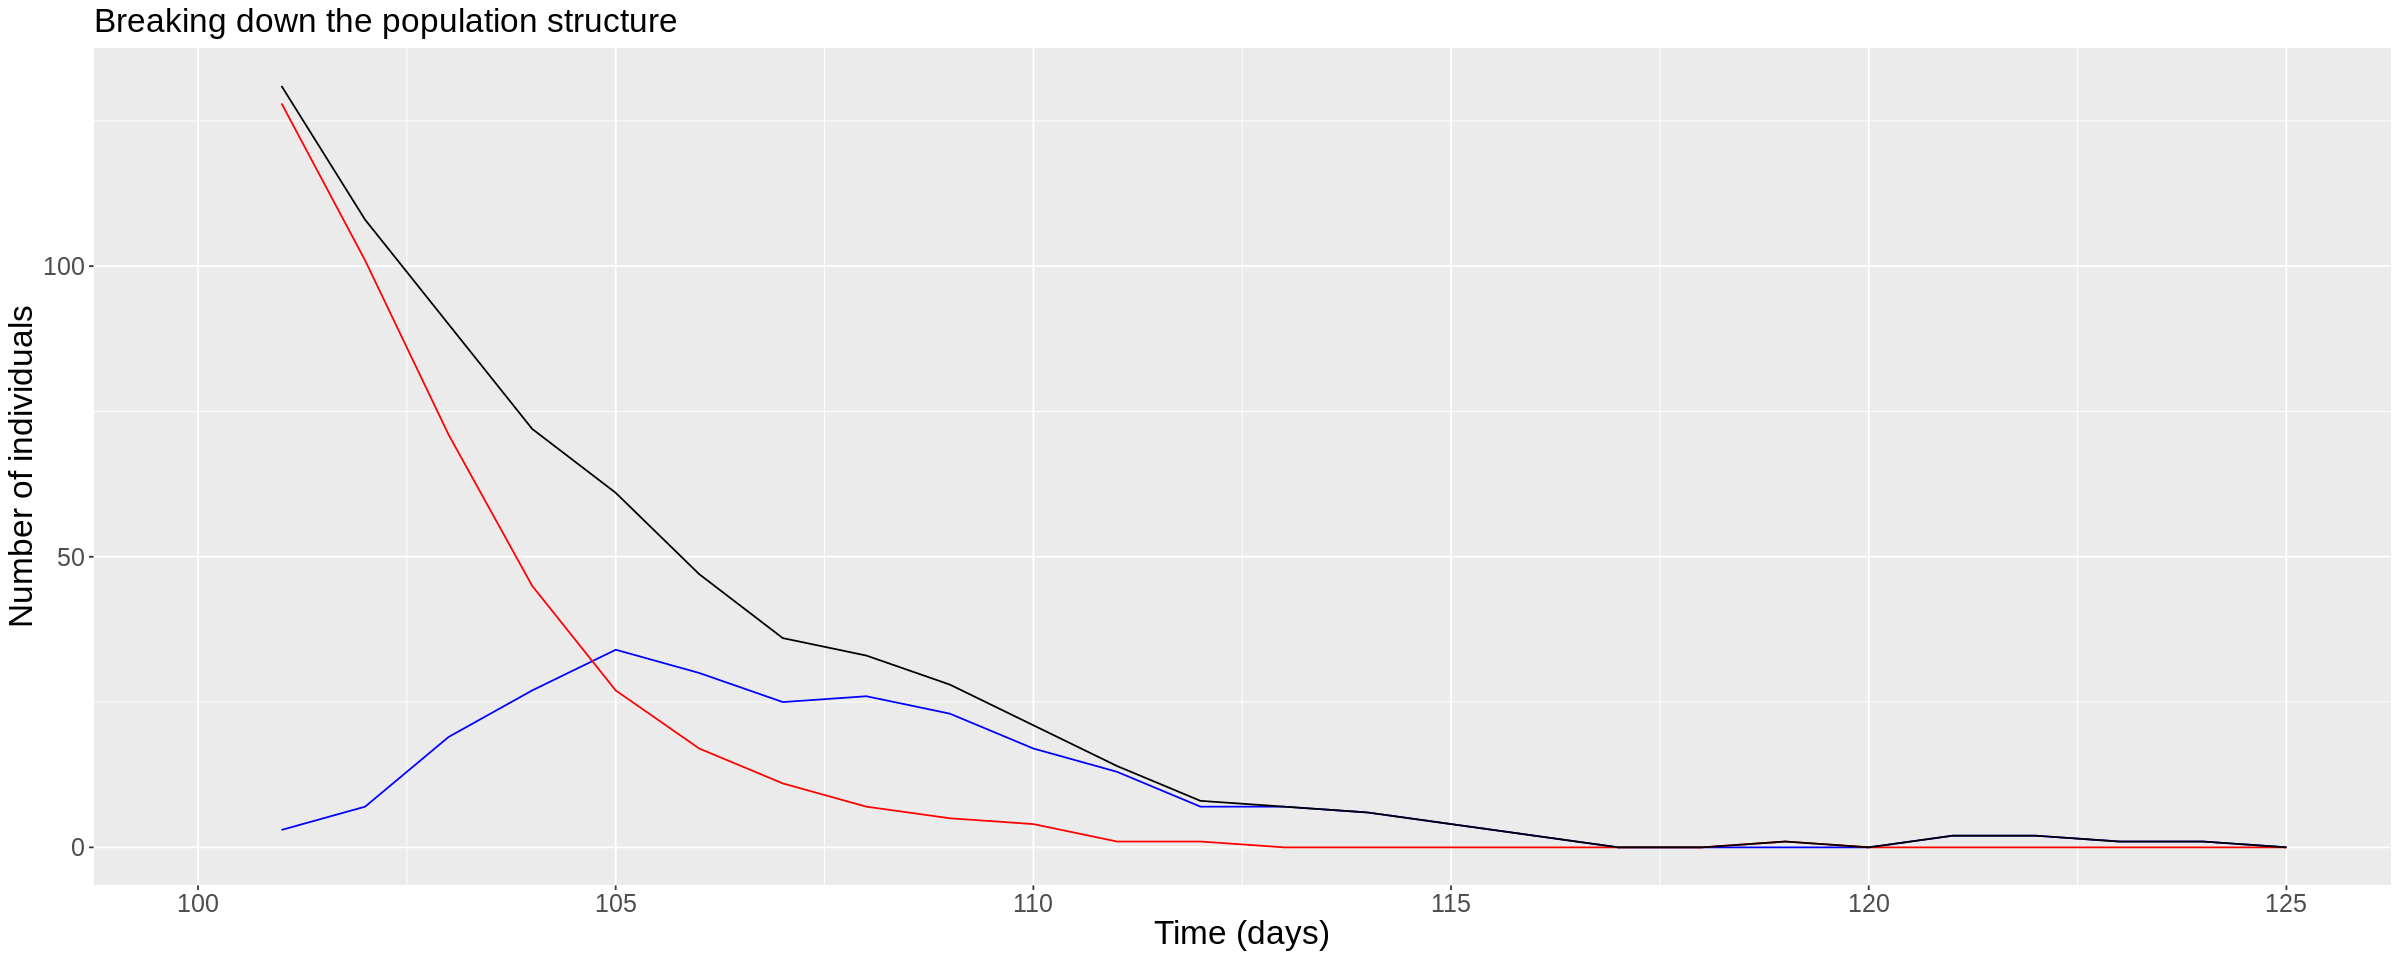

In [25]:
t_cohorte=100
dt_cohorte=1
nb_alive_NS<- c()
nb_alive_S<- c()
for (i in (t_cohorte+dt_cohorte):t_final){
    pop<-sim_out$population[[i]]
nb_alive_NS<-c(nb_alive_NS,  dim(pop[pop$birth>=t_cohorte& pop$birth<t_cohorte+dt_cohorte& is.na(pop$death) & pop$smurfness==0 ,])[1])
nb_alive_S<-c(nb_alive_S,  dim(pop[pop$birth>=t_cohorte& pop$birth<t_cohorte+dt_cohorte& is.na(pop$death) & pop$smurfness==1 ,])[1])  
}

cohort_surv <- as.data.frame(cbind((t_cohorte+dt_cohorte):t_final,nb_alive_NS,nb_alive_S))
colnames(cohort_surv) <- c("time", "NS_alive", "S_alive")
ggplot(cohort_surv, aes(x=time))+
    geom_line(aes(y=S_alive), colour="blue")+
    geom_line(aes(y=NS_alive), colour='red')+
    geom_line(aes(y=NS_alive+S_alive))+
    labs(title ="Breaking down the population structure", y="Number of individuals", x="Time (days)")+
    theme(axis.text.y = element_text(size = 15),
          axis.text.x = element_text(size = 15),
          axis.title = element_text(size = 20),
          plot.title = element_text(size = 20))+
          xlim(t_cohorte, t_cohorte+25)

In [26]:
dim(all_dead[all_dead$entry!=0,])

[1] 8919    6

Warning message:
“Removed 870 row(s) containing missing values (geom_path).”
Warning message:
“Removed 870 row(s) containing missing values (geom_path).”
Warning message:
“Removed 870 row(s) containing missing values (geom_path).”


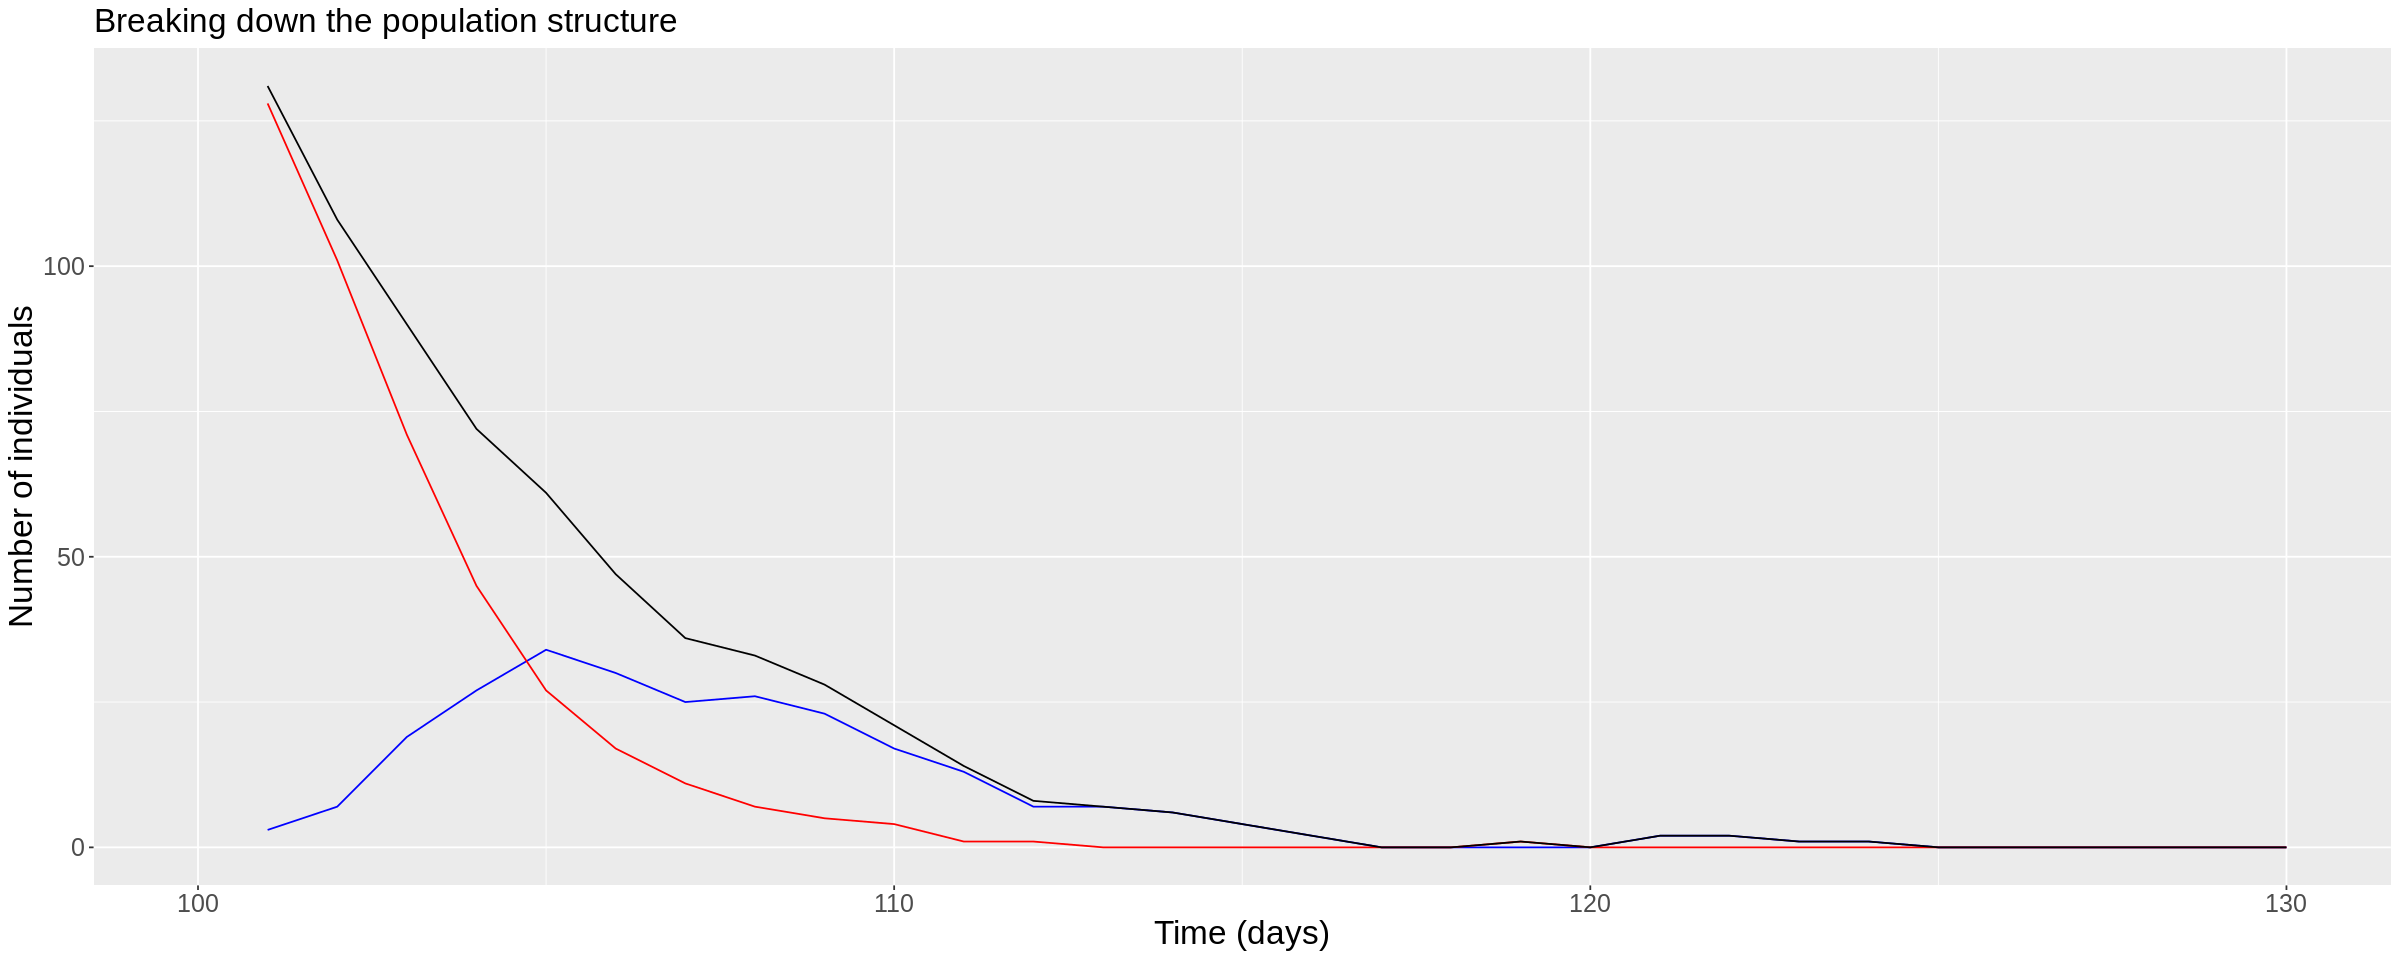

In [27]:
t_cohorte=100
dt_cohorte=1
nb_alive_NS<- c()
nb_alive_S<- c()
for (i in (t_cohorte+dt_cohorte):t_final){
    pop<-sim_out$population[[i]]
nb_alive_NS<-c(nb_alive_NS,  dim(pop[pop$birth>=t_cohorte& pop$birth<t_cohorte+dt_cohorte& is.na(pop$death) & pop$smurfness==0 ,])[1])
nb_alive_S<-c(nb_alive_S,  dim(pop[pop$birth>=t_cohorte& pop$birth<t_cohorte+dt_cohorte& is.na(pop$death) & pop$smurfness==1 ,])[1])  
}
cohort_surv <- as.data.frame(cbind((t_cohorte+dt_cohorte):t_final,nb_alive_NS,nb_alive_S))
colnames(cohort_surv) <- c("time", "NS_alive", "S_alive")
ggplot(cohort_surv, aes(x=time))+
    geom_line(aes(y=S_alive), colour="blue")+
    geom_line(aes(y=NS_alive), colour='red')+
    geom_line(aes(y=NS_alive+S_alive))+
    labs(title ="Breaking down the population structure", y="Number of individuals", x="Time (days)")+
    theme(axis.text.y = element_text(size = 15),
          axis.text.x = element_text(size = 15),
          axis.title = element_text(size = 20),
          plot.title = element_text(size = 20))+
          xlim(100,130)

Warning message in plot.xy(xy, type, ...):
“plot type 'line' will be truncated to first character”


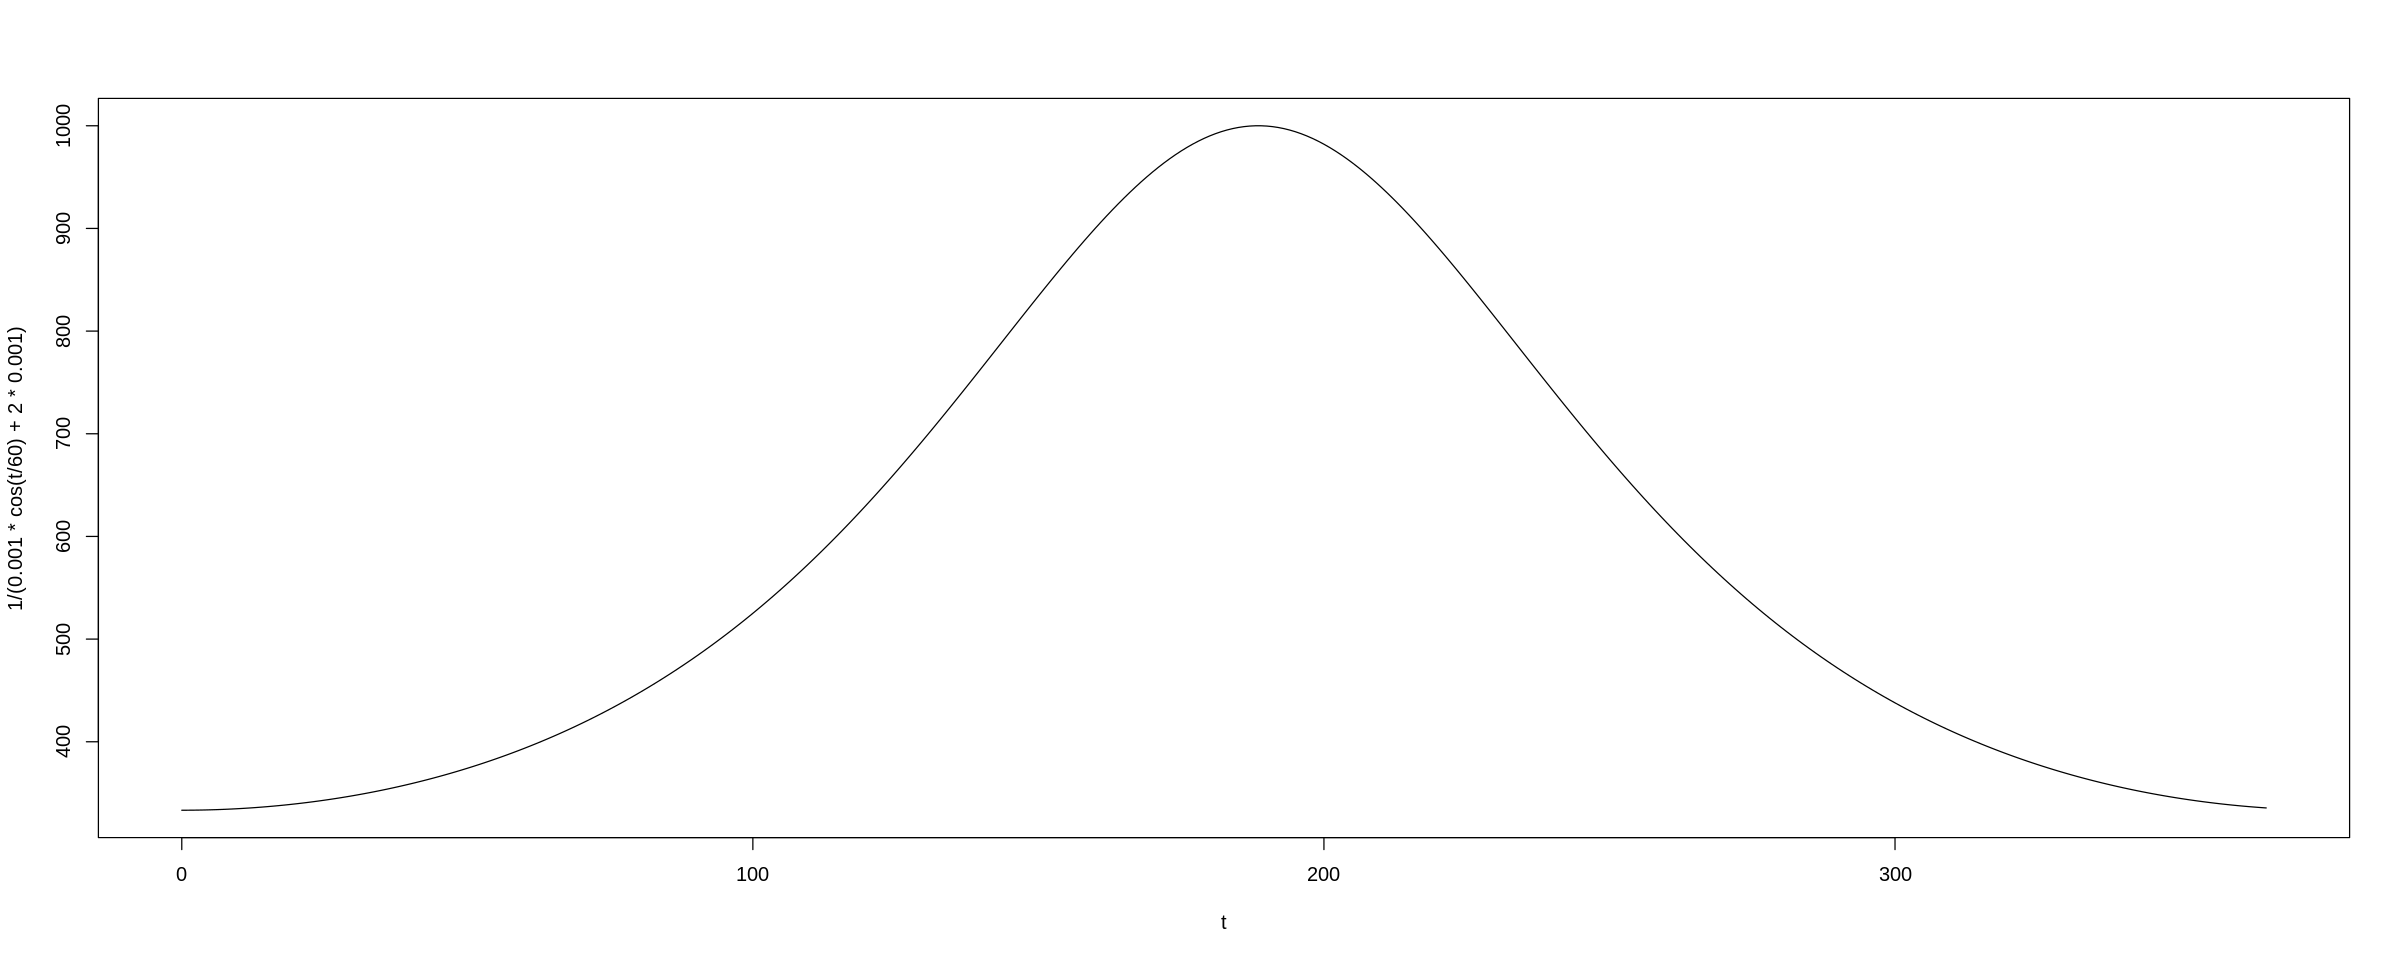

In [28]:
t <- 0:365
plot(t,1/( 1e-3 * cos(t/60)+2*1e-3), type = 'line')